## Connect Wflow to a 1D model

If you have a **Wflow** model, one of the applications is that you would like to connect it to a another model such as a 1D hydraulic model like Delft3D or HEC-RAS or a 1D water allocation model like RIBASIM where wflow would give them both river discharge at the boundaries of these models and the runoff generated within the 1D model domain.

HydroMT-Wflow uses a new function **setup_1dmodel_connection** to try and help you out with these steps. What it does is:

- Add gauges at the 1D model upstream boundaries to exchange river discharge.
- Derive the sub-basins draining into the 1D model river to exchange the amount of water that enters the river (river inwater).
- Optionally, while deriving the sub-basins, large sub-basins can be taken out as tributaries and river discharge is exchanged instead.

Through this notebook we will see some examples of how to use this new function.

### Import packages

In this notebook, we will update out Wflow model using python rather than the **update** command line and do some plotting to visualize the outputs of the function.

In [1]:
from hydromt_wflow import WflowModel
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  # plot projection

### Connecting to a 1D model

To connect Wflow to a 1D model, we will use the [setup_1dmodel_connection](https://deltares.github.io/hydromt_wflow/latest/_generated/hydromt_wflow.WflowModel.setup_1dmodel_connection.html).

It uses a 1D river geometry file and there are two methods to connect the models:

- `subbasin_area`: creates subcatchments linked to the 1d river based
on an area threshold (area_max) for the subbasin size. With this method,
if a tributary is larger than the `area_max`, it will be connected to
the 1d river directly.
- `nodes`: subcatchments are derived based on the 1driver nodes (used as
gauges locations). With this method, large tributaries can also be derived
separately using the `add_tributaries` option and adding a `area_max`
threshold for the tributaries.

So let's first load our wflow model and the river file of the 1D model we would like to connect to:

In [2]:
# Load the wflow model of Piave
mod = WflowModel(root="wflow_piave_subbasin", mode="r")

# Open the river of the 1D model
rivers1d = gpd.read_file("data/rivers.geojson")

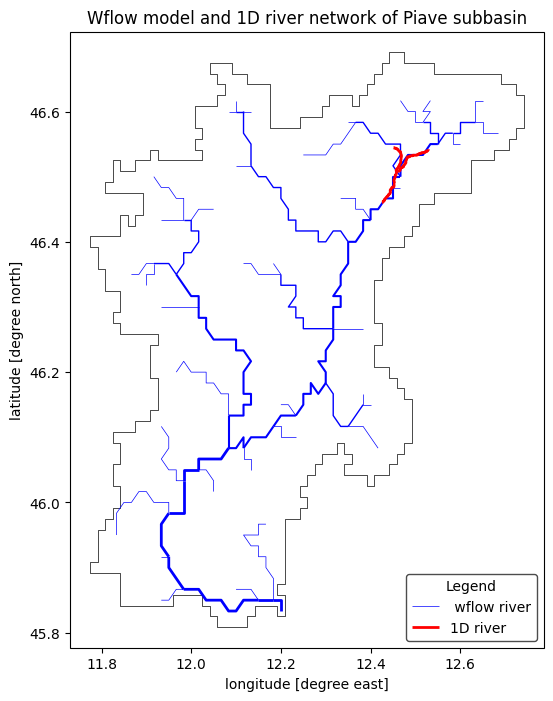

In [3]:
# And plot the model and the river
# Plot
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = mod.grid.raster.box.to_crs(3857).buffer(5e3)
extent = np.array(bbox.to_crs(mod.grid.raster.crs).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# Wflow
# plot rivers with increasing width with stream order
mod.rivers.plot(
    ax=ax, lw=mod.rivers["strord"] / 2, color="blue", zorder=3, label=" wflow river"
)
# plot the basin boundary
mod.basins.boundary.plot(ax=ax, color="k", linewidth=0.5)

# 1D river
rivers1d.to_crs(mod.crs).plot(
    ax=ax, color="red", linewidth=2, zorder=4, label="1D river"
)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Wflow model and 1D river network of Piave subbasin")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

#### Subbasin area connection method and tributaries

We see that our 1D model is located in the Northern part of our Wflow model.

Let's connect the two using the ``subbasin_area`` method and including tributaries for subbasins that are larger than 30 km2.

In [4]:
# Run the setup_1d_model_connection function
mod.setup_1dmodel_connection(
    river1d_fn=rivers1d,
    connection_method="subbasin_area",
    area_max=30.0,
    add_tributaries=True,
    include_river_boundaries=True,
    mapname="1dmodel",
    update_toml=True,
    toml_output="netcdf",
)

We can see than in that case the toml was already updated to save the relevant outputs for our new gauges and subcatch:

In [5]:
mod.config["netcdf"]

{'path': 'output_scalar.nc',
 'variable': [{'name': 'Q',
   'map': 'gauges_1dmodel',
   'parameter': 'lateral.river.q_av'},
  {'name': 'Qlat',
   'map': 'subcatch_riv_1dmodel',
   'parameter': 'lateral.river.inwater',
   'reducer': 'sum'}]}

And let's visualize our results:

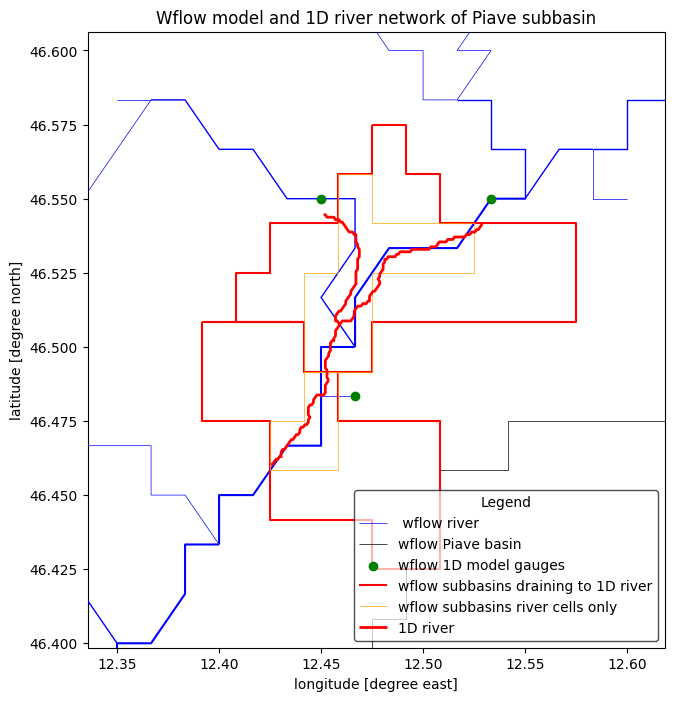

In [6]:
# And plot the model and the river
# Plot
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = gpd.GeoDataFrame(geometry=[box(*rivers1d.total_bounds)], crs=rivers1d.crs)
bbox = bbox.buffer(10e3)
extent = np.array(bbox.to_crs(mod.grid.raster.crs).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# Wflow
# plot rivers with increasing width with stream order
mod.rivers.plot(
    ax=ax, lw=mod.rivers["strord"] / 2, color="blue", zorder=3, label=" wflow river"
)
# plot the basin boundary
mod.basins.boundary.plot(ax=ax, color="k", linewidth=0.5, label="wflow Piave basin")
# Add the boundry gauges and tributary gauges
if "gauges_1dmodel" in mod.geoms:
    mod.geoms["gauges_1dmodel"].plot(
        ax=ax, color="green", zorder=4, label="wflow 1D model gauges"
    )
# Add the full subbasins and river only
mod.geoms["subcatch_1dmodel"].boundary.plot(
    ax=ax, color="red", zorder=4, label="wflow subbasins draining to 1D river"
)
mod.geoms["subcatch_riv_1dmodel"].boundary.plot(
    ax=ax,
    color="orange",
    linewidth=0.5,
    zorder=4,
    label="wflow subbasins river cells only",
)

# 1D river
rivers1d.to_crs(mod.crs).plot(
    ax=ax, color="red", linewidth=2, zorder=5, label="1D river"
)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Wflow model and 1D river network of Piave subbasin")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

Let's try the same if we do not include river boundaries:

In [7]:
# Run the setup_1d_model_connection function
mod1 = WflowModel(root="wflow_piave_subbasin", mode="r")
mod1.setup_1dmodel_connection(
    river1d_fn=rivers1d,
    connection_method="subbasin_area",
    area_max=30.0,
    add_tributaries=True,
    include_river_boundaries=False,
    mapname="1dmodel",
    update_toml=True,
    toml_output="netcdf",
)

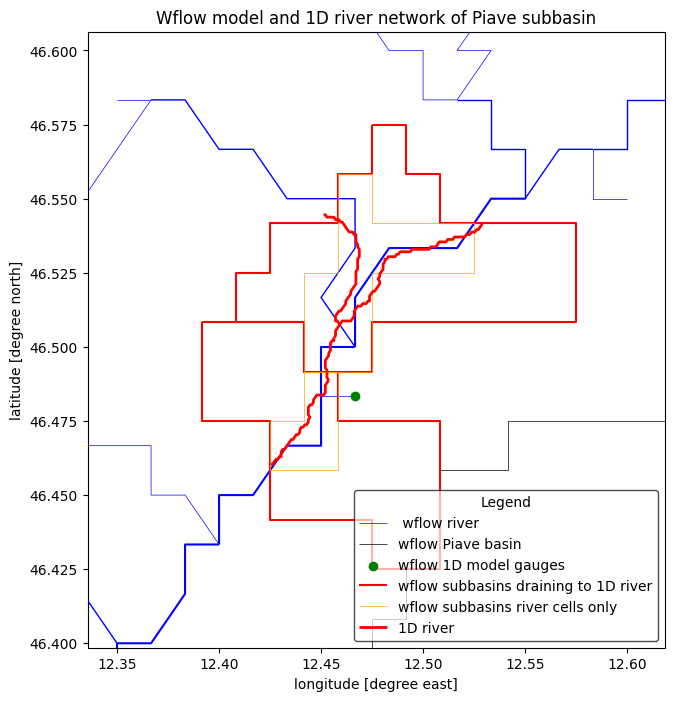

In [8]:
# And plot the model and the river
# Plot
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = gpd.GeoDataFrame(geometry=[box(*rivers1d.total_bounds)], crs=rivers1d.crs)
bbox = bbox.buffer(10e3)
extent = np.array(bbox.to_crs(mod.grid.raster.crs).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# Wflow
# plot rivers with increasing width with stream order
mod1.rivers.plot(
    ax=ax, lw=mod1.rivers["strord"] / 2, color="blue", zorder=3, label=" wflow river"
)
# plot the basin boundary
mod1.basins.boundary.plot(ax=ax, color="k", linewidth=0.5, label="wflow Piave basin")
# Add the boundry gauges and tributary gauges
mod1.geoms["gauges_1dmodel"].plot(
    ax=ax, color="green", zorder=4, label="wflow 1D model gauges"
)
# Add the full subbasins and river only
mod1.geoms["subcatch_1dmodel"].boundary.plot(
    ax=ax, color="red", zorder=4, label="wflow subbasins draining to 1D river"
)
mod1.geoms["subcatch_riv_1dmodel"].boundary.plot(
    ax=ax,
    color="orange",
    linewidth=0.5,
    zorder=4,
    label="wflow subbasins river cells only",
)

# 1D river
rivers1d.to_crs(mod1.crs).plot(
    ax=ax, color="red", linewidth=2, zorder=5, label="1D river"
)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Wflow model and 1D river network of Piave subbasin")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

#### Nodes connection method

This connection is different as we create subbasins only for all nodes of the 1D river file. Let's see the difference:

In [9]:
# Run the setup_1d_model_connection function
mod1 = WflowModel(root="wflow_piave_subbasin", mode="r")
mod1.setup_1dmodel_connection(
    river1d_fn=rivers1d,
    connection_method="nodes",
    area_max=30.0,
    add_tributaries=False,
    include_river_boundaries=False,
    mapname="1dmodel",
    update_toml=False,
)

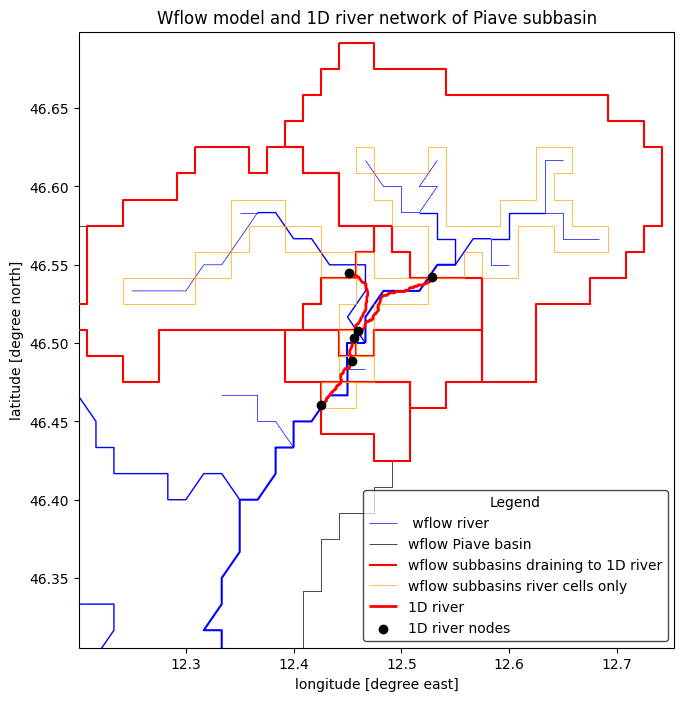

In [10]:
# And plot the model and the river
# Plot
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = gpd.GeoDataFrame(geometry=[box(*rivers1d.total_bounds)], crs=rivers1d.crs)
bbox = bbox.buffer(25e3)
extent = np.array(bbox.to_crs(mod.grid.raster.crs).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# Wflow
# plot rivers with increasing width with stream order
mod1.rivers.plot(
    ax=ax, lw=mod1.rivers["strord"] / 2, color="blue", zorder=3, label=" wflow river"
)
# plot the basin boundary
mod1.basins.boundary.plot(ax=ax, color="k", linewidth=0.5, label="wflow Piave basin")
# Add the full subbasins and river only
mod1.geoms["subcatch_1dmodel"].boundary.plot(
    ax=ax, color="red", zorder=4, label="wflow subbasins draining to 1D river"
)
mod1.geoms["subcatch_riv_1dmodel"].boundary.plot(
    ax=ax,
    color="orange",
    linewidth=0.5,
    zorder=4,
    label="wflow subbasins river cells only",
)

# 1D river
rivers1d.to_crs(mod1.crs).plot(
    ax=ax, color="red", linewidth=2, zorder=5, label="1D river"
)
# Plot the rivers1d nodes
nodes = []
for bi, branch in rivers1d.iterrows():
    nodes.append([Point(branch.geometry.coords[0]), bi])  # start
    nodes.append([Point(branch.geometry.coords[-1]), bi])  # end
gdf_nodes = gpd.GeoDataFrame(nodes, columns=["geometry", "river_id"], crs=rivers1d.crs)
# Drop duplicates geometry
gdf_nodes = gdf_nodes[~gdf_nodes.geometry.duplicated(keep="first")]
gdf_nodes.to_crs(mod1.crs).plot(ax=ax, color="black", zorder=6, label="1D river nodes")

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Wflow model and 1D river network of Piave subbasin")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)